## Review for results of GW150914

In [65]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
from scipy.stats import norm
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import importlib
import json
import lal
import bilby

import sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

import importlib
importlib.reload(group_postprocess)

<module 'time_domain_gw_inference.group_postprocess' from '/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/group_postprocess.py'>

### Load data

In [46]:
# Load TD output
run_date = '250619'
data = group_postprocess.load_run_settings_from_directory(
    f'./output/{run_date}_output/',
    filename_dict={'full':'full_0.0seconds'}, 
)

# Get samples
TD_samples = data['dfs']['full']

# Likelihood manager
lm = data['runs']['full']['likelihood_manager'] 

Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


In [78]:
# chirp mass
def get_chirpmass(m1, m2): 
    return np.power(m1*m2,3./5)*np.power(m1+m2,-1./5)
    
TD_samples['chirp_mass'] = get_chirpmass(TD_samples['mass1'], TD_samples['mass2'])
TD_samples['polarization'] = TD_samples['polarization'] % np.pi
TD_samples['cos_tilt1'] = np.cos(TD_samples['tilt1'])
TD_samples['cos_tilt2'] = np.cos(TD_samples['tilt2'])

In [55]:
# Load bilby comparison result 
bilby_samples = utils.get_pe_samples(data['dir'] + data['runs']['full']['args'].pe_posterior_h5_file)

### Prior reweighting

In [56]:
# Load bilby prior
bilby_prior = bilby.gw.prior.BBHPriorDict('bilby_prior.prior')

# Draw samples from the prior
bilby_prior_samples = bilby_prior.sample(10000)

In [62]:
bilby_prior

{'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=21.418182160215295, maximum=41.97447913941358, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None),
 'mass_ratio': bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.05, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False),
 'mass_1': Constraint(minimum=1, maximum=1000, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=1, maximum=1000, name='mass_2', latex_label='$m_2$', unit=None),
 'a_1': Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None),
 'a_2': Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None),
 'tilt_1': Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary=None),
 'tilt_2': Sine(minimum=0, maximum=3.141592653589793, name='tilt_2', latex_label='$\\theta_2$', unit=None, boundary=

In [74]:
# Calculate bilby prior weights (masses, distance)
def get_jacobian(m1, m2):

    j = m1**2/(m1+m2)

    mchirp = get_chirpmass(m1, m2)
    mask = (mchirp < bilby_prior['chirp_mass'].minimum) | (mchirp > bilby_prior['chirp_mass'].maximum)
    j[mask] = 0
    
    return j

p_bilby_masses = get_jacobian(TD_samples['mass1'], TD_samples['mass2'])
p_bilby_DL =  bilby_prior['luminosity_distance'].prob(TD_samples['luminosity_distance'])
p_bilby = p_bilby_masses * p_bilby_DL

# Calculate TD prior weights for params of interest (time)
p_TD = norm.pdf(TD_samples['geocenter_time'], lm.reference_time, lm.sigma_time)

# Take their ratio
prior_weights = p_bilby / p_TD

### Plot posteriors

In [82]:
# 15 BBH parameters
# keys = TD inference, values = bilby

parameters = {
    'chirp_mass':'chirp_mass', 
    'mass_ratio':'mass_ratio', 
    'luminosity_distance':'luminosity_distance', 
    'spin1_magnitude':'a_1',
    'spin2_magnitude':'a_2',
    'cos_tilt1':'cos_tilt_1',
    'cos_tilt2':'cos_tilt_2',
    'phi12':'phi_12',
    'theta_jn':'theta_jn',
    'phi_jl':'phi_jl',
    'right_ascension':'ra',
    'declination':'dec',
    'polarization':'psi',
    'phase':'phase',
    'geocenter_time':'geocent_time'
}

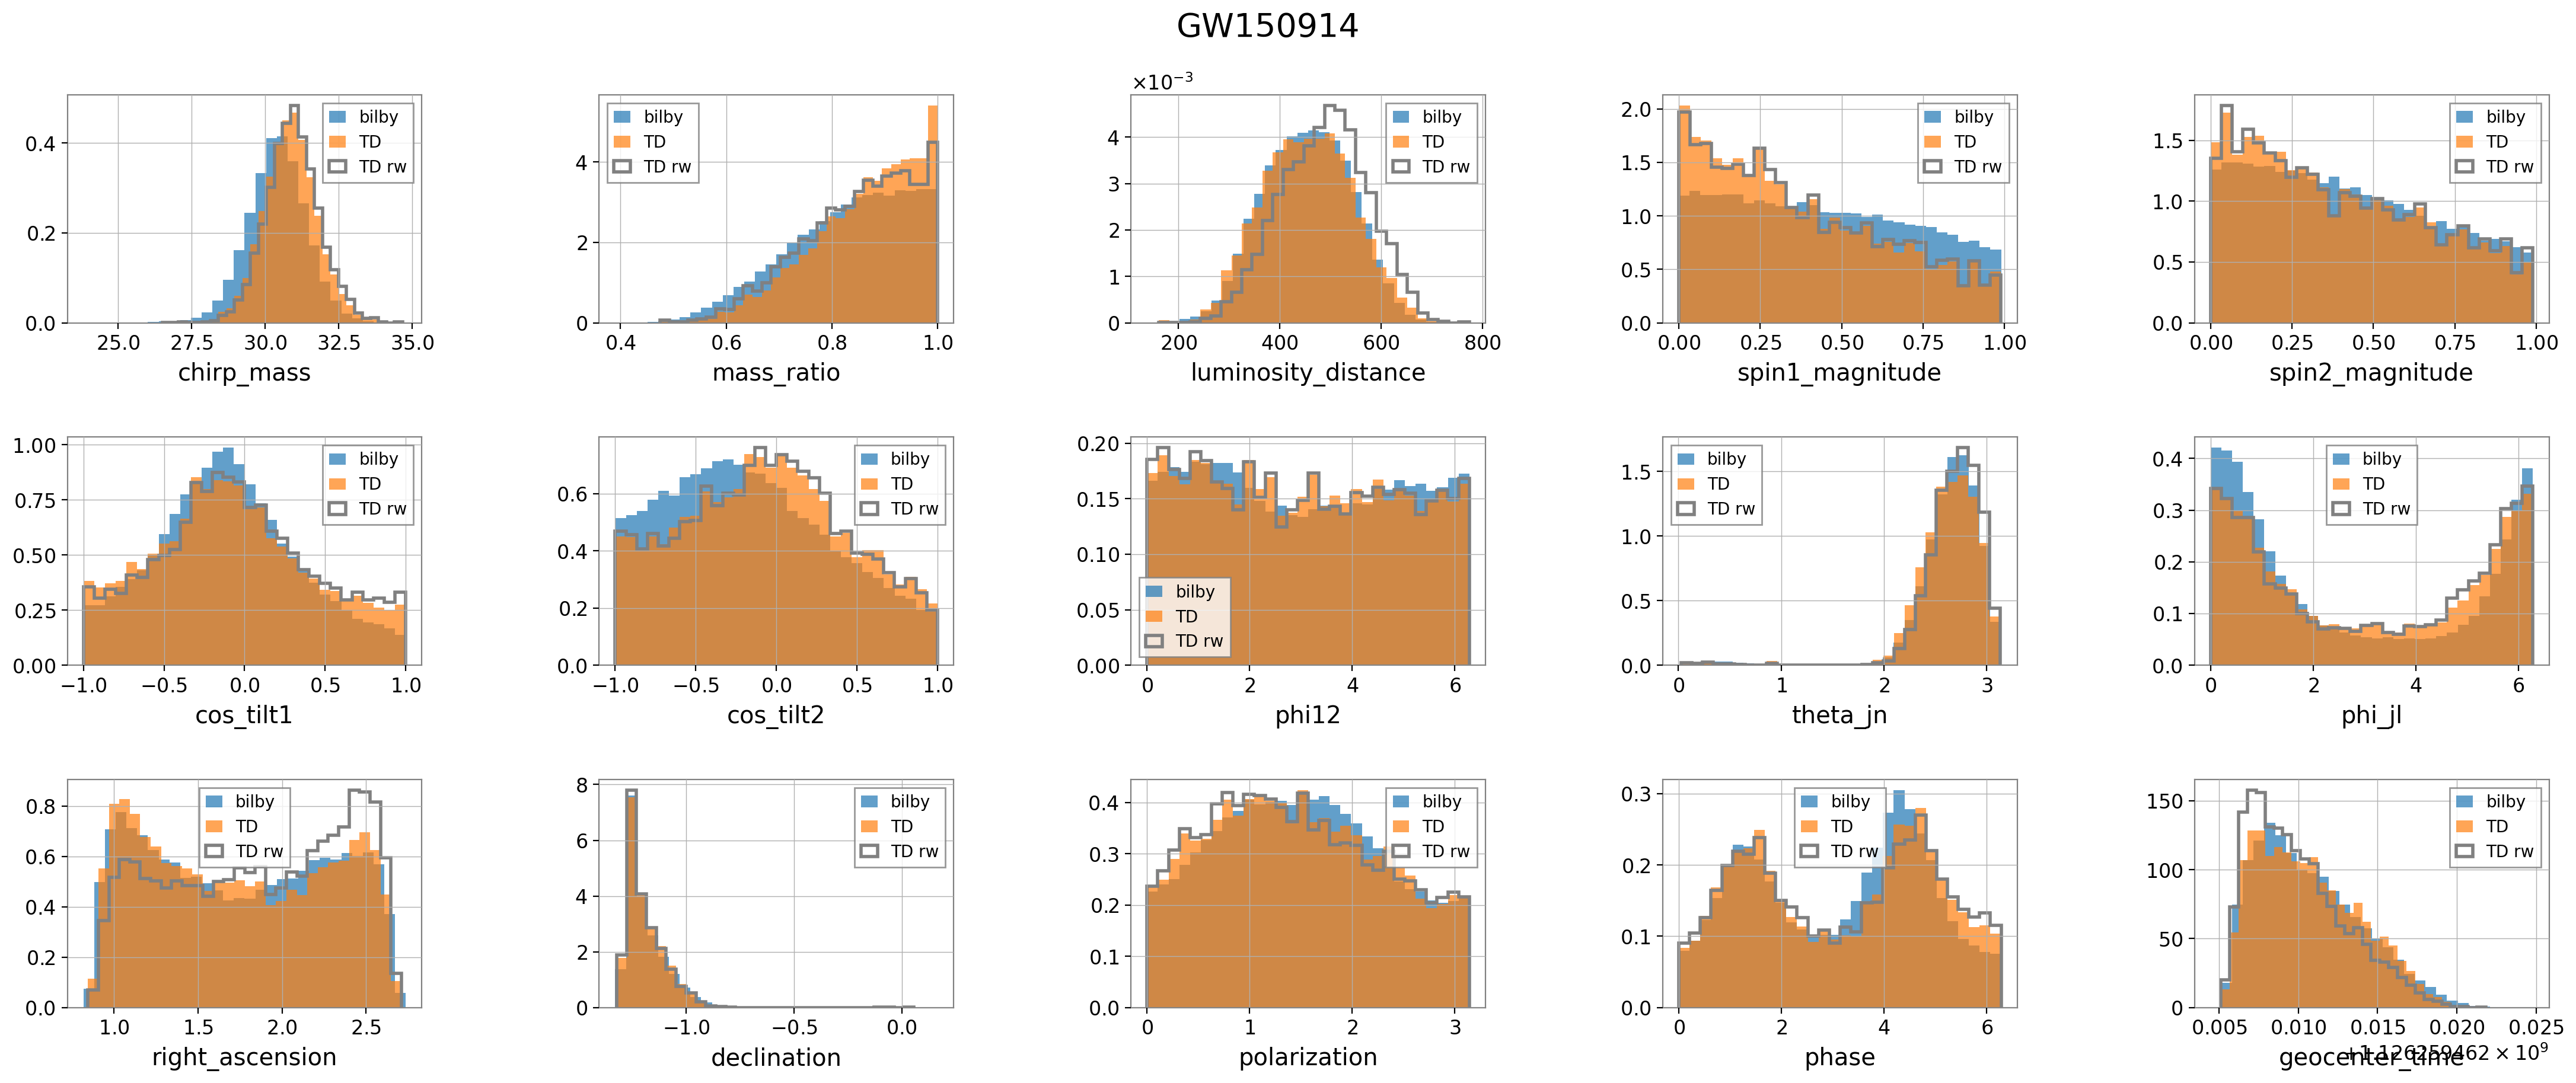

In [88]:
# plot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(27,10))

for k, ax in zip(parameters.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)

    # bilby samples
    ax.hist(bilby_samples[parameters[k]], **hist_kws,  alpha=0.7, label='bilby')

    # time domain samples with reweighted prior
    ax.hist(TD_samples[k], **hist_kws,  alpha=0.7, label='TD')
    ax.hist(TD_samples[k], weights=prior_weights, **hist_kws, histtype='step', lw=2, color='gray', label='TD rw')
   
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle('GW150914', y=0.95, fontsize=20)
plt.savefig('posterior_comparison.png', dpi=300, bbox_inches='tight')
plt.show()